In [229]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil.parser
import math
from datetime import date
from datetime import datetime, timedelta
import altair as alt
alt.data_transformers.disable_max_rows()
alt.data_transformers.enable('json')
import seaborn as sns
import re

In [230]:
today = date.today()
print(today)

2020-06-26


In [231]:
# source: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
ecdc = pd.read_csv("https://opendata.ecdc.europa.eu/covid19/casedistribution/csv", encoding = "utf-8")
ecdc.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp
0,26/06/2020,26,6,2020,460,36,Afghanistan,AF,AFG,38041757.0,Asia
1,25/06/2020,25,6,2020,234,21,Afghanistan,AF,AFG,38041757.0,Asia
2,24/06/2020,24,6,2020,338,20,Afghanistan,AF,AFG,38041757.0,Asia
3,23/06/2020,23,6,2020,310,17,Afghanistan,AF,AFG,38041757.0,Asia
4,22/06/2020,22,6,2020,409,12,Afghanistan,AF,AFG,38041757.0,Asia


In [232]:
#excluding NANs
countries_list = ecdc[ecdc['countryterritoryCode'].notnull()]['countryterritoryCode'].unique()

In [233]:
ecdc['parsed_date'] = [re.sub(r'(\d\d)\/(\d\d)\/(\d\d\d\d)','\g<3>-\g<2>-\g<1>', date) for date in ecdc['dateRep']]
ecdc.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,parsed_date
0,26/06/2020,26,6,2020,460,36,Afghanistan,AF,AFG,38041757.0,Asia,2020-06-26
1,25/06/2020,25,6,2020,234,21,Afghanistan,AF,AFG,38041757.0,Asia,2020-06-25
2,24/06/2020,24,6,2020,338,20,Afghanistan,AF,AFG,38041757.0,Asia,2020-06-24
3,23/06/2020,23,6,2020,310,17,Afghanistan,AF,AFG,38041757.0,Asia,2020-06-23
4,22/06/2020,22,6,2020,409,12,Afghanistan,AF,AFG,38041757.0,Asia,2020-06-22


In [234]:
ecdc['parsed_date'] = [datetime.strptime(date, '%Y-%m-%d') for date in ecdc['parsed_date']]

# Find all fridays

In [235]:
#https://stackoverflow.com/questions/2003870/how-can-i-select-all-of-the-sundays-for-a-year-using-python
from datetime import date, timedelta

def allfridays(year):
    d = date(year, 1, 1)                    # January 1st
    d += timedelta(days = 4 - d.weekday())  # First friday
    while d.year == year:
        yield d
        d += timedelta(days = 7)

In [236]:
for d in allfridays(2020):
    print(d)

2020-01-03
2020-01-10
2020-01-17
2020-01-24
2020-01-31
2020-02-07
2020-02-14
2020-02-21
2020-02-28
2020-03-06
2020-03-13
2020-03-20
2020-03-27
2020-04-03
2020-04-10
2020-04-17
2020-04-24
2020-05-01
2020-05-08
2020-05-15
2020-05-22
2020-05-29
2020-06-05
2020-06-12
2020-06-19
2020-06-26
2020-07-03
2020-07-10
2020-07-17
2020-07-24
2020-07-31
2020-08-07
2020-08-14
2020-08-21
2020-08-28
2020-09-04
2020-09-11
2020-09-18
2020-09-25
2020-10-02
2020-10-09
2020-10-16
2020-10-23
2020-10-30
2020-11-06
2020-11-13
2020-11-20
2020-11-27
2020-12-04
2020-12-11
2020-12-18
2020-12-25


In [237]:
# create class variables
moredouble = '01_moredouble'
more = '02_more'
samesame ='03_samesame'
less = '04_less'
lesshalf = '05_lesshalf'
zerozero ='06_zerozero'

In [238]:
threshold_samesame = 7

In [239]:
friday_data_list = []

for country in countries_list:
    #filter dataframe for one specific country at a time
    filtered_aggregates = ecdc[ecdc['countryterritoryCode']==country]
    for this_friday in allfridays(2020):
        country_dict = {}
        #filter country-specific-dataframe to only contain the last seven days ("this week")
        country_dict['country_ISO'] = country
        seven_days_ago = this_friday-timedelta(7)
        country_dict['which_friday'] = this_friday
        country_dict['seven_days_ago'] = seven_days_ago
        filtered_aggregates_this_week = filtered_aggregates[(filtered_aggregates['parsed_date']<=this_friday) & (filtered_aggregates['parsed_date']>seven_days_ago)]
        cases_this_week = filtered_aggregates_this_week['cases'].sum()
        country_dict['cases_this_week']= cases_this_week
        #filter country-specific-dataframe to only contain the previous seven days ("last week")    
        fourteen_day_ago = this_friday-timedelta(14)
        country_dict['fourteen_days_ago'] = fourteen_day_ago
        filtered_aggregates_last_week = filtered_aggregates[(filtered_aggregates['parsed_date']<=seven_days_ago) &(filtered_aggregates['parsed_date']>fourteen_day_ago)]
        cases_last_week = filtered_aggregates_last_week['cases'].sum()
        country_dict['cases_last_week']= cases_last_week
        # classify country
        if (cases_last_week>0)&(cases_this_week > (cases_last_week * 2)):
            country_dict['trend_class'] = moredouble
        elif cases_this_week >= (cases_last_week+threshold_samesame):
            country_dict['trend_class'] = more
        elif (cases_last_week == 0)& (cases_this_week !=0):
            country_dict['trend_class'] = more
        elif (cases_last_week==0)&(cases_this_week==0):
            country_dict['trend_class'] = zerozero
        elif (cases_this_week == cases_last_week):
            country_dict['trend_class'] = samesame
        elif (cases_this_week == 0)&(cases_last_week != 0):
            country_dict['trend_class'] = less
        elif cases_last_week+threshold_samesame > cases_this_week > cases_last_week -threshold_samesame:
            country_dict['trend_class'] = samesame
        elif cases_this_week < cases_last_week/2:
            country_dict['trend_class'] = lesshalf
        elif cases_this_week <= cases_last_week-threshold_samesame:
            country_dict['trend_class'] = less
        else:
            country_dict['trend_class'] = 'youMISSEDsth'
        # add it all to the list of country dicts
        friday_data_list.append(country_dict)


/Users/grueng/.virtualenvs/dw_data/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  del sys.path[0]
/Users/grueng/.virtualenvs/dw_data/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.


In [240]:
all_week_trend = pd.DataFrame(friday_data_list)
all_week_trend.head()

,cases_last_week,cases_this_week,country_ISO,fourteen_days_ago,seven_days_ago,trend_class,which_friday
0,0,0,AFG,2019-12-20,2019-12-27,06_zerozero,2020-01-03
1,0,0,AFG,2019-12-27,2020-01-03,06_zerozero,2020-01-10
2,0,0,AFG,2020-01-03,2020-01-10,06_zerozero,2020-01-17
3,0,0,AFG,2020-01-10,2020-01-17,06_zerozero,2020-01-24
4,0,0,AFG,2020-01-17,2020-01-24,06_zerozero,2020-01-31


In [241]:
#filter to contain only data points up until the latest available friday
all_week_trend_data = all_week_trend[all_week_trend['which_friday'] <= today]
all_week_trend_data.head()

,cases_last_week,cases_this_week,country_ISO,fourteen_days_ago,seven_days_ago,trend_class,which_friday
0,0,0,AFG,2019-12-20,2019-12-27,06_zerozero,2020-01-03
1,0,0,AFG,2019-12-27,2020-01-03,06_zerozero,2020-01-10
2,0,0,AFG,2020-01-03,2020-01-10,06_zerozero,2020-01-17
3,0,0,AFG,2020-01-10,2020-01-17,06_zerozero,2020-01-24
4,0,0,AFG,2020-01-17,2020-01-24,06_zerozero,2020-01-31


In [242]:
#refactor data for plotting
value_counts = pd.DataFrame()

for friday in all_week_trend_data['which_friday']:
    weekly_trend = all_week_trend_data[all_week_trend_data['which_friday']==friday]
    weekly_trend_df = weekly_trend['trend_class'].value_counts().rename_axis('trend_class').reset_index(name='#_countries_in_class')
    weekly_trend_df['time'] = friday
    value_counts = pd.concat([value_counts, weekly_trend_df])

In [243]:
value_counts.head()

,trend_class,#_countries_in_class,time
0,06_zerozero,208,2020-01-03
1,02_more,1,2020-01-03
0,06_zerozero,208,2020-01-10
1,05_lesshalf,1,2020-01-10
0,06_zerozero,206,2020-01-17


In [244]:
value_counts['calendar_week'] = [day.isocalendar()[1] for day in value_counts['time']]

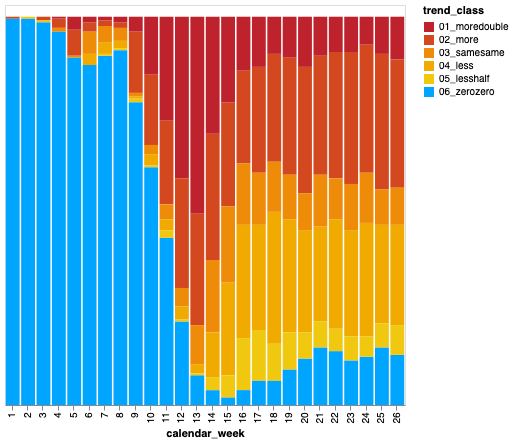

In [245]:
bars = alt.Chart(value_counts).mark_bar().encode(
    x=alt.X('calendar_week:N'),
    y=alt.Y('sum(#_countries_in_class):Q', stack='zero', axis = None),
    color=alt.Color('trend_class:N',scale=alt.Scale(domain=[moredouble, more,samesame,less, lesshalf,zerozero],range=["#BE232D","#D44820","#EE8C0A","#F0AA00","#F0C80F","#00A5FF"]))
)

bars.properties(width=400, height=400)